In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [14]:
import sqlite3
import pandas as pd

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM models', conn)

for col in ['val_acc', 'train_acc', 'time', 'flops', 'macs', 'params', 'exp_id']:
    df[col] = df[col].apply(eval)
df.sort_values(by='val_acc', ascending=False, inplace=True)

In [15]:
from sophius.encode import Encoder, str_to_vec

encoder = Encoder()

df['vec'] = df['hash'].apply(str_to_vec)
df.vec.apply(len).value_counts()

vec
5     708
6     485
4     432
7     129
3     106
11     74
13     65
14     62
15     57
12     49
10     48
8      37
16     35
17     26
18     25
9      25
19     21
20     16
21     15
23      9
22      7
24      6
25      5
26      4
27      3
35      1
29      1
37      1
30      1
Name: count, dtype: int64

<Axes: >

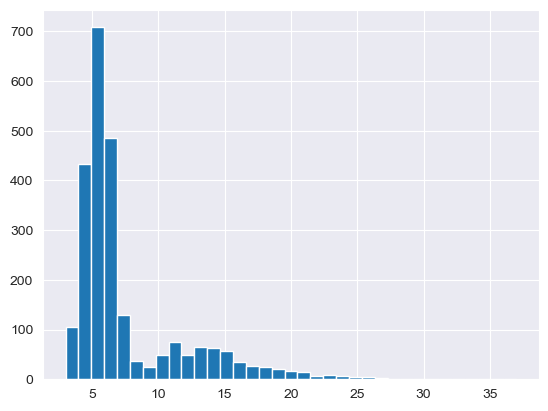

In [16]:
df.vec.apply(len).hist(bins=35)

In [17]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Dataset definition remains the same
class SequenceDataset(Dataset):
    """
    Simple dataset, loads sequences to GPU as list tensors
    Args:
        sequences (list): list of 1D arrays
        targets: 1D array of target values    
    """
    def __init__(self, sequences, targets):
        self.sequences = [torch.tensor(seq).type(torch.cuda.FloatTensor) for seq in sequences]
        self.targets = torch.tensor(targets).view(-1, 1).type(torch.cuda.FloatTensor)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = self.sequences[index]
        target = self.targets[index]
        return sequence, target

In [18]:
import torch
from torch.utils.data import random_split
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

dataset = SequenceDataset(df.vec.tolist(), df.val_acc)
train, val = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(RANDOM_SEED))

In [19]:
class LSTMRegressor(pl.LightningModule):
    def __init__(self, 
                 input_dim=32,                 
                 hidden_dim=128, 
                 num_layers=1, 
                 dropout=0.0, 
                 lr=1e-3,
                 gamma=0.9,
                 num_epochs=None,
                 **_):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters
        self.lstm = torch.nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout, 
            batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1)
        self.lr = lr
        self.gamma = gamma
        self.val_loss = None

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)       
        return self.fc(hidden[-1])

    def training_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        loss = F.mse_loss(outputs, targets)
        # self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
        # self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        loss = F.mse_loss(outputs, targets)
    #     # self.log('val_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
    #     self.val_loss = loss
        return loss    

    def on_train_end(self):
        # Log the hyperparameter metric directly here
        trainer = self.trainer
        if trainer.logger:
            trainer.logger.log_hyperparams({"hp_metric": self.val_loss})
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            'optimizer': opt,
            'lr_scheduler': torch.optim.lr_scheduler.ExponentialLR(opt, gamma=self.gamma)
        }

In [20]:
from copy import deepcopy
import numpy as np

class SequenceLoader:
    """ Simple data loader 
    """    
    def __init__(self, dataset = None, batch_size = 1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.len_dict, self.rev_len_dict = self._get_len_dicts()
        self._rev_len_dict = deepcopy(self.rev_len_dict)
        self._idx = 0
    
    def _get_len_dicts(self):
        sequences = [x[0].cpu().numpy() for x in self.dataset]
        df = pd.DataFrame([sequences]).T.rename(columns={0:'seq'})
        df['len'] = df.seq.apply(len)
        
        len_dict = df.reset_index()['len'].to_dict()  # idx -> len
        rev_len_dict = df.reset_index().groupby('len')['index'].apply(list).to_dict()  # len -> ids list        
        
        # shuffle ids list
        for v in rev_len_dict.values():
            np.random.shuffle(v)
            
        return len_dict, rev_len_dict
    
    def __iter__(self):
        self.rev_len_dict = deepcopy(self._rev_len_dict)
        while sum(len(v) for v in self.rev_len_dict.values()) > 0:
            # sample first random index
            ids_list = [i for v in self.rev_len_dict.values() for i in v]
            i = np.random.choice(ids_list)
            
            # get len of that sequence
            batch_ids = []
            seq_len = self.len_dict[i]
            
            # fill batch with seq indices with same size
            for j in range(self.batch_size):    
                # try pop until ids list not empty
                if len(self.rev_len_dict[seq_len]) != 0:
                    batch_ids.append(self.rev_len_dict[seq_len].pop())
                else:
                    # oversampling from full list
                    batch_ids.append(np.random.choice(self._rev_len_dict[seq_len]))
                
            # print(f"Batch idx {i}:", batch_ids)
            batch_ids = torch.tensor(batch_ids).type(torch.cuda.IntTensor)            
            X = torch.stack([self.dataset[i][0] for i in batch_ids])
            y = torch.stack([self.dataset[i][1] for i in batch_ids])
            yield X, y                        
    
    def __len__(self):
        return len(self.dataset) // self.batch_size

In [25]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# train_loader = DataLoader(train, batch_size=1, shuffle=False, num_workers=0)
# val_loader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)
# train_loader = SimpleLoader(train)
# val_loader = SimpleLoader(val)
train_loader = SequenceLoader(train, batch_size=8)
val_loader = SequenceLoader(val, batch_size=8)

hparams = {
    'lr': 1e-3,
    'gamma': 1,
    'hidden_dim': 32,
    'num_layers': 4,
    'dropout': 0.4,
    'input_dim': 32,
    'num_epochs': 20,
}

# Initialize model
model = LSTMRegressor(**hparams)

from tqdm import tqdm

# disable validation progress bar
from pytorch_lightning.callbacks import TQDMProgressBar
class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        return tqdm(disable=True)


# Create PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=hparams['num_epochs'], 
                     accelerator='gpu', 
                     # log_every_n_steps=100,
                     callbacks=[CustomProgressBar()],
                     )

# Train the model
model.train()
# print(model.device)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\korol\PycharmProjects\sophius\notebooks\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 33.8 K
1 | fc   | Linear | 33    
--------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 306/306 [00:02<00:00, 119.83it/s, loss=0.0015, v_num=0] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 306/306 [00:02<00:00, 119.41it/s, loss=0.0015, v_num=0]


mse: 0.0014
r2: 0.8977


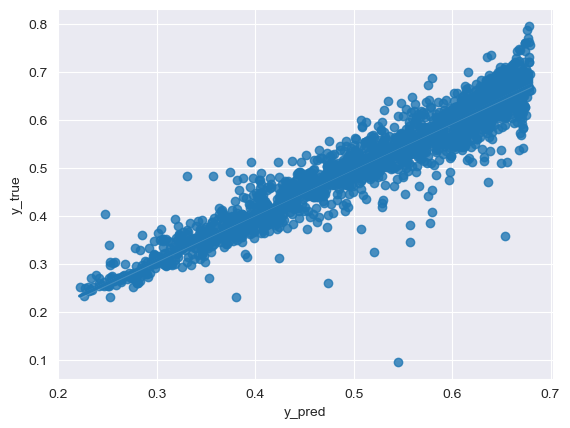

In [26]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def plot_results(model, dataset):
    res = pd.DataFrame(columns=['y_pred', 'y_true'])
    model.eval()
    model = model.cuda()
    
    with torch.no_grad():
        for seq, y_true in dataset:
            y_pred = model(seq.unsqueeze(0)).item()
            y_true = y_true.item()
            res.loc[len(res)] = [y_pred, y_true]
    
    print(f'mse: {mean_squared_error(res.y_true, res.y_pred):.4f}')
    print(f'r2: {r2_score(res.y_true, res.y_pred):.4f}')
    sns.regplot(res, x='y_pred', y='y_true');

plot_results(model, train)

mse: 0.0029
r2: 0.7977


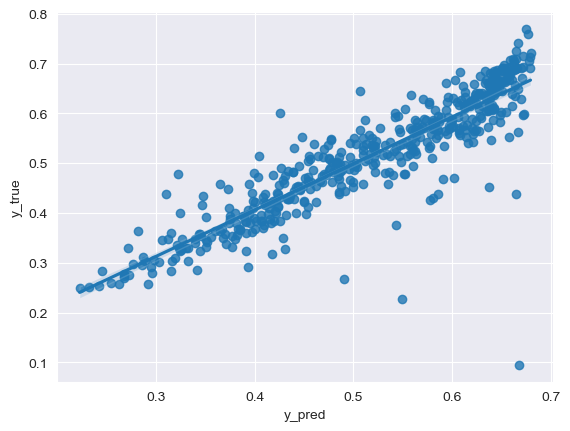

In [27]:
plot_results(model, val)